<a href="https://colab.research.google.com/github/SL-207/Mixed-Input-Price-Classifier/blob/main/Mixed_Input_Price_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Download Dataset and Import Dependencies

In [1]:
!kaggle datasets download -d iamarjunchandra/akaike-dataset

Dataset URL: https://www.kaggle.com/datasets/iamarjunchandra/akaike-dataset
License(s): unknown
 99% 130M/132M [00:02<00:00, 82.9MB/s]
100% 132M/132M [00:02<00:00, 50.4MB/s]


In [2]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
from zipfile import ZipFile
from tqdm.auto import tqdm
from timeit import default_timer as timer

import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### 2. Examine and Preprocess data

In [4]:
with ZipFile('akaike-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()
    print('Data extracted successfully')

data_path = Path('dataset')
image_path = data_path/'train'

Data extracted successfully


In [17]:
df_train = pd.read_csv(data_path/'train.csv')
df_test = pd.read_csv(data_path/'test.csv')

In [6]:
df_train.head()

,image_file,age(yrs),special_discount_available,price_range,category
0,da9c681961.jpg,> 2 & < 5,0,medium,Watches
1,e3c1627707.jpg,0,1,extremely high,Real Estate
2,31a0c21872.jpg,0,0,medium,Watches
3,117c888796.jpg,> 5,0,high,Real Estate
4,bdbf040271.jpg,0,1,low,Perfumes


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   image_file                  1925 non-null   object
 1   age(yrs)                    1925 non-null   object
 2   special_discount_available  1925 non-null   int64 
 3   price_range                 1925 non-null   object
 4   category                    1925 non-null   object
dtypes: int64(1), object(4)
memory usage: 75.3+ KB


In [ ]:
df_train.isnull().sum()

image_file                    0
age(yrs)                      0
special_discount_available    0
price_range                   0
category                      0
dtype: int64

In [18]:
df_train['image_file'] = 'dataset/train/' + df_train.category + '/' + df_train['image_file']
df_test['image_file'] = 'dataset/test/' + df_test.category + '/' + df_test['image_file']

In [19]:
class_names = list(df_train['price_range'].unique())
class_names

['medium', 'extremely high', 'high', 'low', 'extremely low']

In [20]:
# Encode target variable
category_encoder = LabelEncoder()

df_train['price_range'] = category_encoder.fit_transform(df_train['price_range'])

In [21]:
class_values = list(df_train['price_range'].unique())
print(class_values)
class_dict = {c:i for c, i in zip(class_names, class_values)}
print(class_dict)

[4, 0, 2, 3, 1]
{'medium': 4, 'extremely high': 0, 'high': 2, 'low': 3, 'extremely low': 1}


In [22]:
# Reorganize class names by labels
sorted_class_names = list(range(len(class_names)))
for name in class_names:
    pos = class_dict[name]
    sorted_class_names[pos] = name

class_names = sorted_class_names
class_names

['extremely high', 'extremely low', 'high', 'low', 'medium']

In [23]:
df_train.groupby('price_range').count()

,image_file,age(yrs),special_discount_available,category
price_range,,,,
0,361,361,361,361
1,311,311,311,311
2,487,487,487,487
3,339,339,339,339
4,427,427,427,427


In [24]:
# One hot encoding Age and Price
df_train = pd.get_dummies(df_train, columns=['age(yrs)'], prefix='age')
df_test = pd.get_dummies(df_test, columns=['age(yrs)'], prefix='age')
df_train.head()
age_cols = ['age_0', 'age_<= 2', 'age_> 2 & < 5', 'age_> 5']
df_train[age_cols] = df_train[age_cols].astype(np.float32)
df_test[age_cols] = df_train[age_cols].astype(np.float32)

df_train = pd.get_dummies(df_train, columns=['category'], prefix='item')
df_train.head()
item_cols = ['item_Cars', 'item_Perfumes', 'item_Real Estate', 'item_Watches']
df_train[item_cols] = df_train[item_cols].astype(np.float32)
df_test[item_cols] = df_train[item_cols].astype(np.float32)

In [ ]:
torch.tensor(df_train[item_cols].iloc[:,0]).shape

torch.Size([1925])

In [ ]:
df_train.head()

,image_file,special_discount_available,price_range,age_0,age_<= 2,age_> 2 & < 5,age_> 5,item_Cars,item_Perfumes,item_Real Estate,item_Watches
0,dataset/train/Watches/da9c681961.jpg,0,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,dataset/train/Real Estate/e3c1627707.jpg,1,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,dataset/train/Watches/31a0c21872.jpg,0,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,dataset/train/Real Estate/117c888796.jpg,0,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,dataset/train/Perfumes/bdbf040271.jpg,1,3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
df_test.head()

,image_file,special_discount_available,category,age_0,age_<= 2,age_> 2 & < 5,age_> 5,item_Cars,item_Perfumes,item_Real Estate,item_Watches
0,dataset/test/Real Estate/7c6ea62d91.jpg,1,Real Estate,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,dataset/test/Perfumes/77bf0d5441.jpg,0,Perfumes,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,dataset/test/Real Estate/8a7dbaeeb4.jpg,0,Real Estate,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,dataset/test/Cars/1e5afc3bd9.jpg,1,Cars,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,dataset/test/Perfumes/87a230400d.jpg,0,Perfumes,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### 3. Examining images

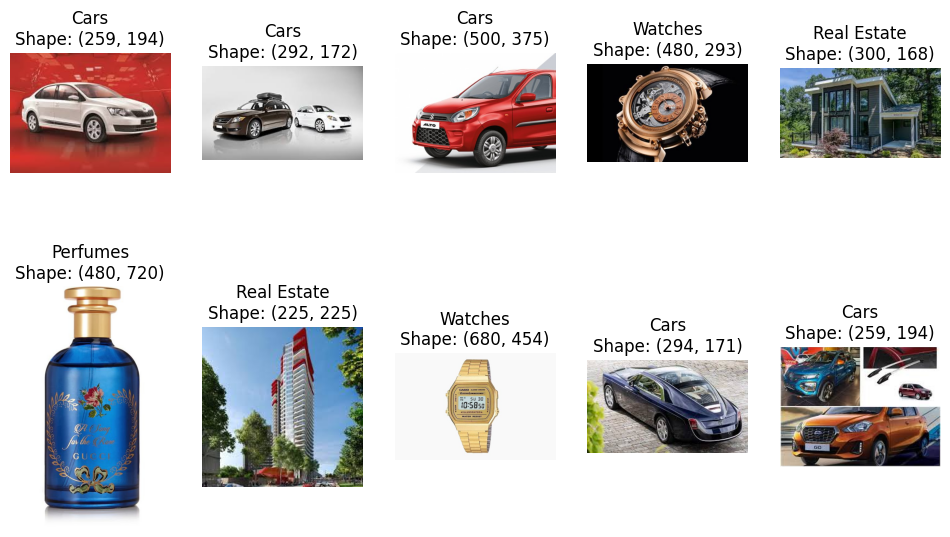

In [25]:
from typing import Union

def plot_random_images(data_path: str | Union[Path, str], n: int, seed: int=None):
    if seed:
        random.seed(seed)

    if n > 10:
        n = 10
        print('n exceeds maximum... setting n to 10')

    img_paths = list(image_path.glob('*/*.jpg'))
    selected_paths = random.sample(img_paths, k=n)

    plt.figure(figsize=(12, 7))
    for i, img_path in enumerate(selected_paths):
        img = Image.open(img_path)

        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.axis(False)

        label = img_path.parent.stem
        shape = f'\nShape: {img.size}'
        plt.title(label + shape)

plot_random_images(image_path, n=10)

### 4. Writing a Custom Dataset class

In [69]:
data_transforms = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

In [70]:
class CustomDataset(Dataset):
    """Creates custom dataset for mixed input data of numerical features and images

    Args:
        df (pandas.core.frame.DataFrame): pandas dataframe containing tabular data
        pred_cols (list[str]): list of predictor column names
        target_col (str): name of dataframe column containing target variable
        transform (torch.utils.data.transforms): pytorch transform for image data
    """
    def __init__(self,
                 df: pd.core.frame.DataFrame,
                 transform: torchvision.transforms=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Get image tensor
        image_path = self.df.loc[index, 'image_file']
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)

        # Get tabular tensor matrix and label
        discount = self.df.loc[index, 'special_discount_available']
        ages = self.df.loc[index, age_cols]
        items = self.df.loc[index, item_cols]

        dis_tensor = torch.tensor(discount).unsqueeze(dim=0)
        age_tensor = torch.tensor(ages)
        item_tensor = torch.tensor(items)
        num_data = torch.cat((dis_tensor, age_tensor, item_tensor))

        label = torch.tensor(self.df.loc[index, 'price_range'])

        return image, num_data, label

### 5. Creating Dataset and Dataloader

In [133]:
dataset = CustomDataset(df=df_train, transform=data_transforms)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
torch.manual_seed(42)
train_data, val_data = random_split(dataset=dataset, lengths=[train_size, val_size])

In [ ]:
train_data[0]

(tensor([[[0.4510, 0.3176, 0.2000,  ..., 0.1059, 0.0902, 0.0275],
          [0.2667, 0.2667, 0.6510,  ..., 0.0706, 0.0510, 0.0314],
          [0.2392, 0.6667, 0.6588,  ..., 0.0667, 0.0549, 0.0431],
          ...,
          [0.1922, 0.1922, 0.2000,  ..., 0.2314, 0.2314, 0.2392],
          [0.1922, 0.1922, 0.2000,  ..., 0.2078, 0.2000, 0.2000],
          [0.2078, 0.2078, 0.2000,  ..., 0.2196, 0.2000, 0.2078]],
 
         [[0.3804, 0.2745, 0.2078,  ..., 0.0980, 0.0706, 0.0157],
          [0.2745, 0.2745, 0.5098,  ..., 0.0706, 0.0392, 0.0196],
          [0.2627, 0.5294, 0.5373,  ..., 0.0588, 0.0431, 0.0275],
          ...,
          [0.2863, 0.2863, 0.2941,  ..., 0.3098, 0.3098, 0.3020],
          [0.2863, 0.2863, 0.2941,  ..., 0.3098, 0.3098, 0.2941],
          [0.3020, 0.3020, 0.2941,  ..., 0.3098, 0.3020, 0.3020]],
 
         [[0.6980, 0.6392, 0.4980,  ..., 0.4000, 0.5294, 0.3529],
          [0.5765, 0.5451, 0.6863,  ..., 0.2235, 0.3294, 0.3020],
          [0.5176, 0.6824, 0.6588,  ...,

In [ ]:
len(train_data), len(val_data)

(1540, 385)

In [134]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_data,
                              batch_size=BATCH_SIZE,
                              num_workers= NUM_WORKERS)

In [125]:
images, num_vars, labels = next(iter(train_dataloader))
images.shape, num_vars.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32, 9]), torch.Size([32]))

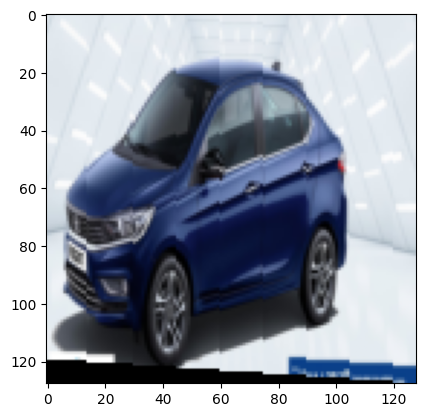

In [99]:
i = random.randint(0, len(images))
plt.imshow(images[i].permute(1,2,0))

In [126]:
print(f'Train data: {len(train_dataloader)} batches of {BATCH_SIZE}')
print(f'Val data: {len(val_dataloader)} batches of {BATCH_SIZE}')

Train data: 49 batches of 32
Val data: 13 batches of 32


### 6. Building Model

In [140]:
class PriceRangeClfModel(nn.Module):
    def __init__(self, input_channels: int, input_features: int, output_features: int, hidden_units: int):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        # self.conv_block2 = nn.Sequential(
        #     nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        #     nn.ReLU(inplace=True),
        #     nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool2d(kernel_size=2)
        # )
        self.flatten = nn.Flatten()
        # self.num_block = nn.Sequential(
        #     nn.Linear(in_features=input_features, out_features=hidden_units),
        #     nn.ReLU(inplace=True),
        #     nn.Dropout()
        # )
        self.clf_layer = nn.Linear(in_features=input_features+(hidden_units*32*32) , out_features=output_features)

    def forward(self, imgs: torch.Tensor, num_features: torch.Tensor) -> torch.Tensor:
        x = self.conv_block(imgs)
        x = self.flatten(x)
        # y = self.num_block(num_features)
        z = torch.cat((x, num_features), dim=1)
        return self.clf_layer(z)

In [141]:
model = PriceRangeClfModel(input_channels=3,
                           input_features=len(num_vars[0]),
                           output_features=len(class_names),
                           hidden_units=10)
model

PriceRangeClfModel(
  (conv_block): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (clf_layer): Linear(in_features=10249, out_features=5, bias=True)
)

In [ ]:
try:
    import torchinfo
except:
    !pip install -qq torchinfo
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
PriceRangeClfModel                       --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       280
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       910
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-6                       910
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       910
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
├─Flatten: 1-3                           --
├─Sequential: 1-4                        --
│    └─Linear: 2-11                      100
│    └─ReLU: 2-12                        --
│    └─Dropout: 2-13                     --
├─Linear: 1-5                            12,850
Total params: 15,960
Trainable params: 15,960
Non-trainable params: 0

In [ ]:
# Test inference
model.eval()
with torch.inference_mode():
    y_logits = model(images, num_vars)
    y_preds = y_logits.softmax(dim=1)
    print(y_preds[:3]) # Print first 3 predictions

torch.Size([32, 2560])
torch.Size([32, 10])
torch.Size([32, 2570])
tensor([[0.1946, 0.1951, 0.1970, 0.2097, 0.2036],
        [0.1970, 0.1910, 0.1984, 0.2122, 0.2014],
        [0.1936, 0.1968, 0.2021, 0.2082, 0.1995]])


### 7. Training Model

In [84]:
try:
    import torchmetrics
except:
    !pip install -qq torchmetrics

from torchmetrics import F1Score, Precision, Recall, ConfusionMatrix

f1_score_fn = F1Score(task='multiclass', num_classes=len(class_names))

In [136]:
def train_step(model: torch.nn.Module,
               train_dl: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer,
               metric_fn):
    train_loss, train_metric = 0, 0
    for b, (b_images, b_features, b_labels) in enumerate(train_dl):
        model.train()
        y_logits = model(b_images, b_features)
        loss = loss_fn(y_logits, b_labels)

        # l1 regularization
        l2_lambda = 0.005
        l2_norm = sum(w.pow(2).sum() for w in model.parameters())
        loss += l2_norm * l2_lambda

        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_preds = y_logits.softmax(dim=1).argmax(dim=1)
        train_metric += metric_fn(y_preds, b_labels)
        # train_acc += (y_preds==b_labels).sum().item()/len(y_preds)

        if b % 16 == 0:
            print(f'Examined {b*BATCH_SIZE}/{len(train_dl.dataset)}')

    train_loss /= len(train_dl)
    train_metric /= len(train_dl)

    return train_loss, train_metric

In [137]:
def val_step(model: torch.nn.Module,
             val_dl: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             optimizer,
             metric_fn):
    model.eval()
    val_loss, val_metric = 0, 0
    with torch.inference_mode():
        for b_images, b_features, b_labels in val_dl:
            y_logits = model(b_images, b_features)
            loss = loss_fn(y_logits, b_labels)
            val_loss += loss.item()

            y_preds = y_logits.softmax(dim=1).argmax(dim=1)
            val_metric += metric_fn(y_preds, b_labels)
            # val_acc += (y_preds==b_labels).sum().item()/len(y_preds)

        val_loss /= len(val_dl)
        val_metric /= len(val_dl)

    return val_loss, val_metric

In [138]:
def train(model: torch.nn.Module,
          train_dl: torch.utils.data.DataLoader,
          val_dl: torch.utils.data.DataLoader,
          epochs: int,
          loss_fn: torch.nn.Module,
          optimizer,
          metric_fn,
          seed: int=None):
    if seed:
        torch.manual_seed(seed)

    results = {'train_loss': [],
               'train_f1': [],
               'val_loss': [],
               'val_f1': []}

    for epoch in tqdm(range(epochs)):
        print(f'Epoch {epoch}\n------')
        train_loss, train_metric = train_step(model=model, train_dl=train_dl, loss_fn=loss_fn, optimizer=optimizer, metric_fn=metric_fn)
        val_loss, val_metric = val_step(model=model, val_dl=val_dl, loss_fn=loss_fn, optimizer=optimizer, metric_fn=metric_fn)
        print(f'\nTrain loss {train_loss:.4f} | Train F1 score {train_metric * 100:.1f}% | Validation loss {val_loss:.4f} | Validation F1 score {val_metric * 100:.1f}%\n')

        results['train_loss'].append(train_loss)
        results['train_f1'].append(train_metric)
        results['val_loss'].append(val_loss)
        results['val_f1'].append(val_metric)

    return results

In [142]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 10
SEED = 42

start = timer()
results = train(model=model,
      train_dl=train_dataloader,
      val_dl=val_dataloader,
      epochs=EPOCHS,
      loss_fn=loss_fn,
      optimizer=optimizer,
      metric_fn=f1_score_fn,
      seed=SEED)
print(f'<< Train time: {timer()-start} >>')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0
------
Examined 0/1540
Examined 512/1540
Examined 1024/1540
Examined 1536/1540

Train loss 1.6107 | Train F1 score 32.8% | Validation loss 1.5467 | Validation F1 score 37.0%

Epoch 1
------
Examined 0/1540
Examined 512/1540
Examined 1024/1540
Examined 1536/1540

Train loss 1.5384 | Train F1 score 36.4% | Validation loss 1.4711 | Validation F1 score 37.5%

Epoch 2
------
Examined 0/1540
Examined 512/1540
Examined 1024/1540
Examined 1536/1540

Train loss 1.4835 | Train F1 score 37.6% | Validation loss 1.4353 | Validation F1 score 37.7%

Epoch 3
------
Examined 0/1540
Examined 512/1540
Examined 1024/1540
Examined 1536/1540

Train loss 1.4666 | Train F1 score 36.7% | Validation loss 1.4148 | Validation F1 score 36.8%

Epoch 4
------
Examined 0/1540
Examined 512/1540
Examined 1024/1540
Examined 1536/1540

Train loss 1.4439 | Train F1 score 38.7% | Validation loss 1.3968 | Validation F1 score 39.4%

Epoch 5
------
Examined 0/1540
Examined 512/1540
Examined 1024/1540
Examined 1536/154

### 8. Save and Reload model

In [143]:
# Save model
model_path = Path('models')
model_path.mkdir(exist_ok=True, parents=True)
save_dict = {
    'model': model.state_dict(),
    'results': results
}
torch.save(save_dict, f=model_path/'mixed_input_model.pt')

# Reload model
load_model = PriceRangeClfModel(input_channels=3, input_features=len(num_vars[0]), output_features=len(class_names), hidden_units=10)
load_dict = torch.load(f=model_path/'mixed_input_model.pt')
load_model.load_state_dict(load_dict['model'])
results_loaded = load_dict['results']
load_model

PriceRangeClfModel(
  (conv_block): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (clf_layer): Linear(in_features=10249, out_features=5, bias=True)
)

### 9. Evaluating model training

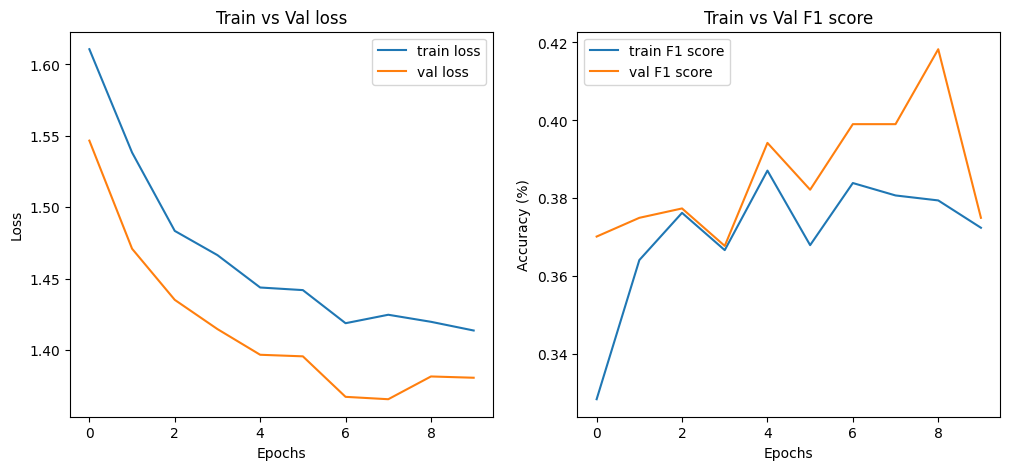

In [145]:
def plot_model_results(results: dict[str, float], epochs: int):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), results['train_loss'], label='train loss')
    plt.plot(range(epochs), results['val_loss'], label='val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Val loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), results['train_f1'], label='train F1 score')
    plt.plot(range(epochs), results['val_f1'], label='val F1 score')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Train vs Val F1 score')
    plt.legend()

plot_model_results(results=results_loaded, epochs=EPOCHS)